In [1]:
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import datetime
import haversine as hs
from sklearn.metrics import r2_score
import folium
import geopandas 
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import train_test_split

C:\Users\Yocef\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Yocef\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Exploratory Data Analysis

In [2]:
data=pd.read_csv('uber.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
data.isna().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [4]:
#We drop the missing data since there's only 1 row of them
data.dropna(inplace=True)

## Analyzing variables: 1- Passenger count

C:\Users\Yocef\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


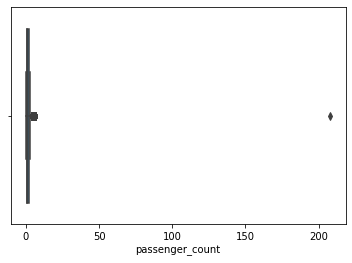

In [5]:
sns.boxplot(data.passenger_count);

C:\Users\Yocef\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


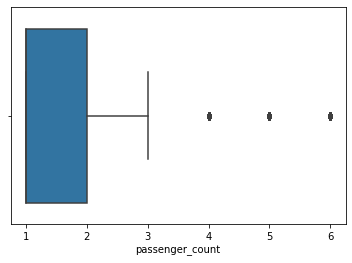

In [6]:
# We know that usually uber can take a maximum of 6 passengers at once
data=data[(data.passenger_count<7) * (data.passenger_count>0)]
sns.boxplot(data['passenger_count']);

## Analyzing variables: 2- Latitudes and Longitudes

C:\Users\Yocef\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


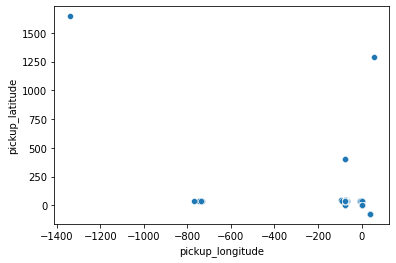

In [7]:
sns.scatterplot(data.pickup_longitude, data.pickup_latitude);

In [8]:
#We delete any trip that resulted in 0 distance:
data=data[~((data['pickup_latitude']==data['dropoff_latitude'])*(data['pickup_longitude']==data['dropoff_longitude']))]

In [9]:
#Calculating trip distances:
distance=[]
for x in zip(zip(data.pickup_latitude , data.pickup_longitude), zip(data.dropoff_latitude , data.dropoff_longitude)):
    distance.append(hs.haversine(x[0], x[1]))
data['distance']=distance
data=data[data.distance>0.5];

C:\Users\Yocef\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='distance', ylabel='Density'>

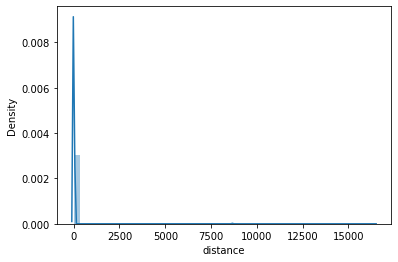

In [10]:
sns.distplot(data.distance)

C:\Users\Yocef\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


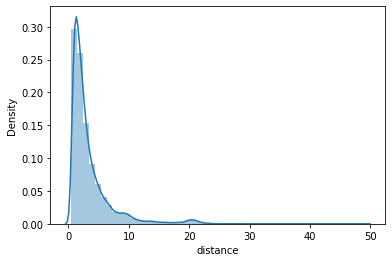

In [11]:
data=data[data.distance<50]
sns.distplot(data.distance);

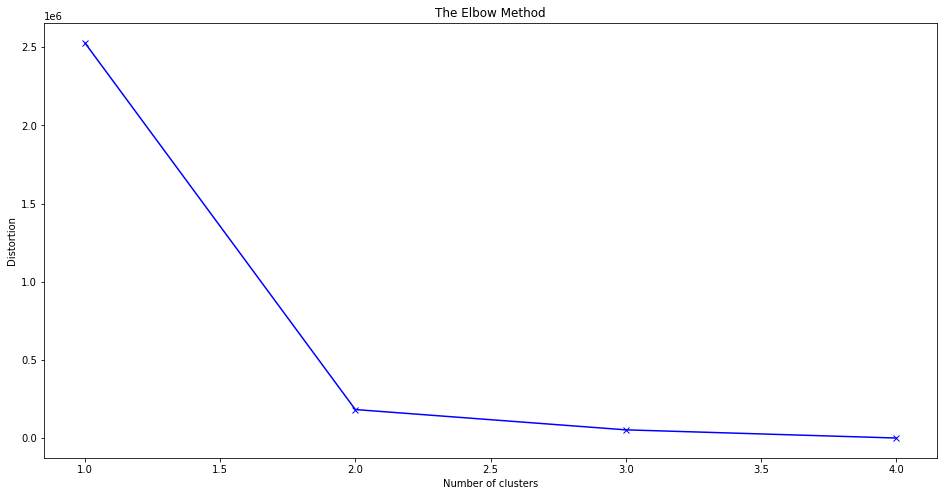

In [12]:
#Devide origin locations of trips using clustering by KMeans
distortions = []
K = range(1,5)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data[['pickup_latitude','pickup_longitude']].values)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()
#we see that k=2 is optimal

In [13]:
#Create a new variable locations
model = KMeans(n_clusters=2)
data['Locations']=model.fit_predict(data[['pickup_latitude','pickup_longitude']].values)

<ipython-input-14-6ec3752c4d36>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True);


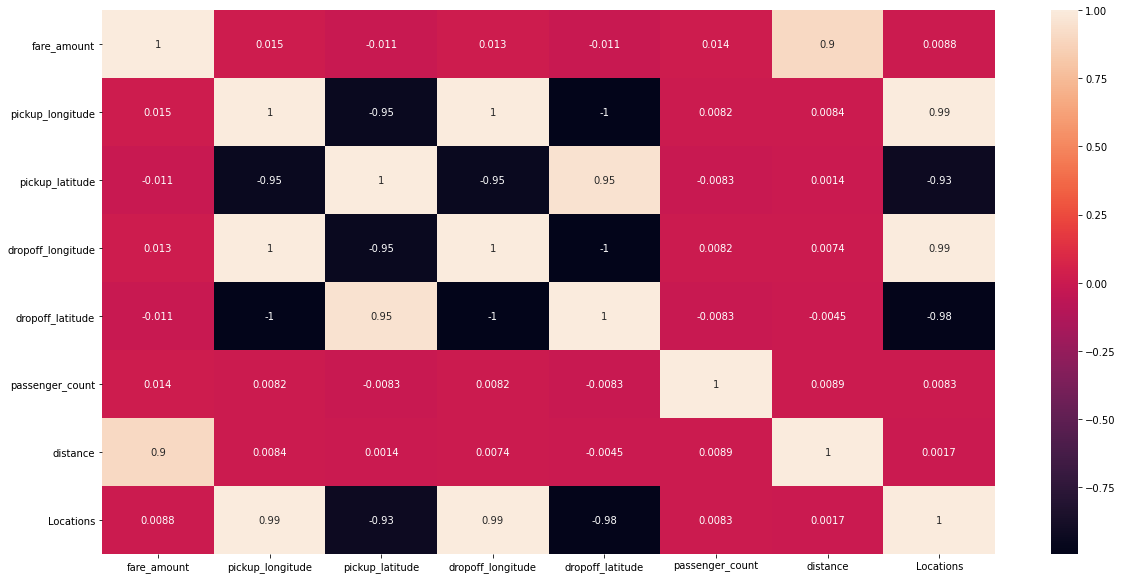

In [14]:
fig= plt.gcf()
fig.set_size_inches(20, 10)
sns.heatmap(data.corr(), annot=True);
#We see that distance has high correlation with the fare amount

## Analyzing variables: 3- Date & time

In [15]:
#Identify the data as datetime data type
data['pickup_datetime']=data['pickup_datetime'].apply(pd.to_datetime)

In [16]:
#Create diffrent variable for hours, days, months and years
data['Years']=data.pickup_datetime.apply(lambda x:x.year)
data['Months']=data.pickup_datetime.apply(lambda x:x.month)
data['Days']=data.pickup_datetime.apply(lambda x:x.day)
data['Hours']=data.pickup_datetime.apply(lambda x:x.round("H").hour)

<ipython-input-24-955f4c1fbc81>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.drop('Locations', axis=1).corr(), annot=True);


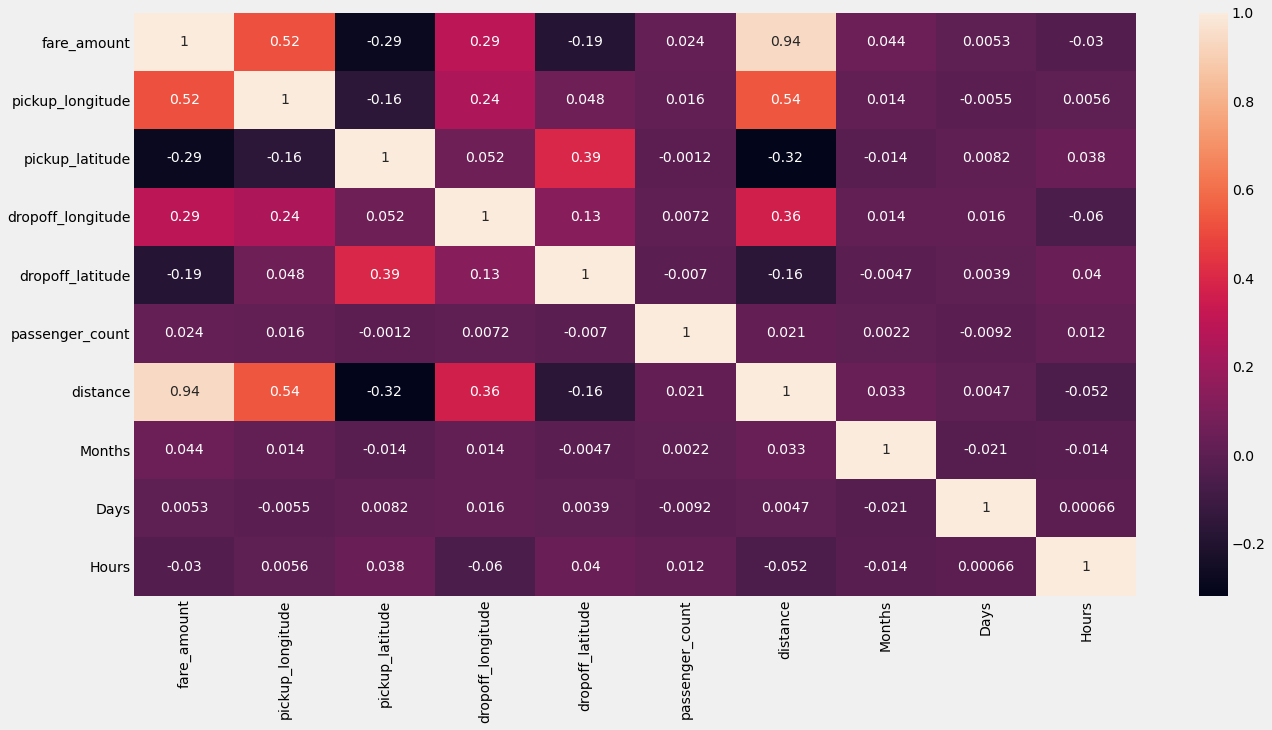

In [24]:
data=data[data.Years==2015]
data.drop('Years', axis=1, inplace=True)
fig= plt.gcf()
fig.set_size_inches(20, 10)
sns.heatmap(data.drop('Locations', axis=1).corr(), annot=True);
#We see that Years is significant so we choose to analyze only the latest year of data (2015)

# Linear Regression

In [18]:
#Creating the linear regression
reg = linear_model.LinearRegression()
df=data
y=df['fare_amount']
X=df.iloc[:, 7:]

In [19]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.33, random_state=42)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
yhat=reg.predict(X_test)
print('R^2 score: {}'.format(r2_score(yhat, y_test)))

R^2 score: 0.8557667743912898


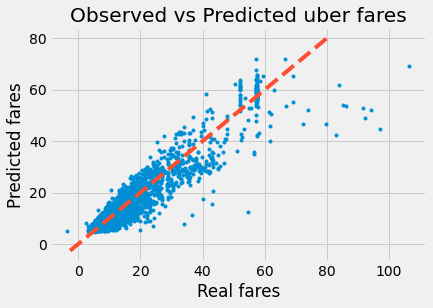

In [39]:
plt.style.use('fivethirtyeight')
plt.plot( y_test,yhat, '.')
line=[0.75*y_test.min(), 0.75*y_test.max()]
plt.plot(line, line , '--')
plt.xlabel('Real fares')
plt.ylabel('Predicted fares')
plt.title('Observed vs Predicted uber fares')
plt.show();